# **Import Dataset**

In [1]:
# Command to print the GPU settings
!nvidia-smi

Mon Oct 19 01:28:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

GPU - Tesla model K80 is assigned and 11441MiB is assigned in processor

---

In [2]:
# importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix,classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import time
%matplotlib inline

In [3]:
# Loading the data from tensorflow datasets 
data = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = data.load_data()

170500096/170498071 [==============================] - 4s 0us/step


# **Data Visualization**

## Printing the shapes of the dataset

In [4]:
# Printing shapes of train and test
print(len(X_train), len(y_train), len(X_test), len(y_test))

50000 50000 10000 10000


## Plotting one sample from each class

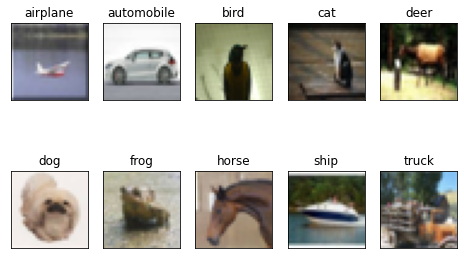

In [5]:
# to make the example replicable
np.random.seed(42)
PYTHONHASHSEED=0

i=10

# class labels
label_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,5))

for i in range(len(label_names)):
  ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0]
  features_idx = X_train[idx,::]
  img_num = np.random.randint(features_idx.shape[0])
  im = features_idx[img_num,::]
  ax.set_title(label_names[i])
  plt.imshow(im)
plt.show()

## Sample image and its class

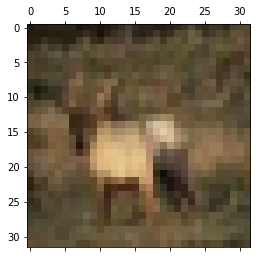

In [6]:
plt.matshow(X_train[3]);

In [7]:
# Target class of this sample is rightfully, DEER
y_train[3], label_names[y_train[3][0]]

(array([4], dtype=uint8), 'deer')

# **Data Pre-Processing**

- The first thing is to pre-process the data as we have data that goes from 0 to 255. This is usually by normalizing all the pixels values within the images by dividing all pixel values by 255.
- The second thing we do to feed the data into our DNN is to flatten the data. So instead of sending the original shape (32 X 32 X 3) we flatten the images to a vector of length 3072
- The third thing we do is to perform one-hot encoding of the target values. So that instead of a output being an integer we convert into a vector of 0s and 1s such that the target vector contains a 1 in its intended class

## Before Preprocessing

In [8]:
# Example of a sample and shape of input
X_train[2], X_train.shape

(array([[[255, 255, 255],
         [253, 253, 253],
         [253, 253, 253],
         ...,
         [253, 253, 253],
         [253, 253, 253],
         [253, 253, 253]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],
 
        ...,
 
        [[113, 120, 112],
         [111, 118, 111],
         [105, 112, 106],
         ...,
         [ 72,  81,  80],
         [ 72,  80,  79],
         [ 72,  80,  79]],
 
        [[111, 118, 110],
         [104, 111, 104],
         [ 99, 106,  98],
         ...,
         [ 68,  75,  73],
         [ 70,  76,  75],
         [ 78,  84,  82]],
 
        [[106, 113, 105],
         [ 99, 106,  98],
         [ 95, 102,  94],
         ...,
         [ 78,  85,  83],
  

In [9]:
# Sample target and shape
y_train[2], y_train.shape

(array([9], dtype=uint8), (50000, 1))

## Normalising and flattening input

In [10]:
# Normalize the data. Before we need to connvert data type to float for computation.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize to range 0-1
X_train = X_train / 255.0
X_test = X_test/ 255.0

# Flatten the data to feed into the DNN
X_train_flattened = X_train.reshape(len(X_train), 32*32*3)
X_test_flattened = X_test.reshape(len(X_test), 32*32*3)

## One hot encoding

In [11]:
# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## After preprocessing

In [12]:
# Sample input after preprocessing
X_train_flattened[2]

array([1.        , 1.        , 1.        , ..., 0.3137255 , 0.3372549 ,
       0.32941177], dtype=float32)

In [13]:
# Sample target after preprocessing
y_train[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [14]:
# Print the shapes of train and test data after preprocessing
print(X_train_flattened.shape, X_test_flattened.shape, y_train.shape, y_test.shape)

(50000, 3072) (10000, 3072) (50000, 10) (10000, 10)


> NOTE: We've created functions that will be used across all three models and comment on each model and its performance under their own subsections.


# **Model building**

- After experimentation we've arrived at the following configuration for our hidden layers.
  - Total hidden layers = 6
  - Each hidden layer has an increasing number of output units (trying to do the opposite doesn't seem to work well despite training the network over several hundred epochs)
- We've added a relu activation within the hidden layers, softmax activation for the final layer. The reason for this is twofold - 
  - RELU typically doesn't suffer from vanish gradient issues
  - SOFTMAX is used to output the final layer activations into multi-class probabilites
- L2 regularisation is added to all hidden layers (except the last layer)
- DROPOUT has been added to the model in the early layers of the model with 20% rate to turn neurons on or off
- Model summary is printed within the function

In [15]:
# Build a model given a model name
def build_model(model_name):

  model = Sequential([
    # dense layer with 3072 input units and 128 output units
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001), input_shape=(3072,)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.20),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    # softmax layer with 10 output units for target classes
    Dense(10, activation='softmax'),
    ], model_name)

  # print the model summary
  print(model.summary())

  return model

# **Model Compilation**

- Loss function used for this multi-class prediction problem is the categorical cross-entropy loss.
- Optimizer can be individually configured for each different model. We highlight the reasons for selecting a optimizer within the model's subsection.
- Lastly, accuracy is used as metric here

In [16]:
# Function to comile the model given an optimizer
def model_compile(model, optimizer):

  # Compiling the model with the given optimizer
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# **Model Training**

- We define two functions here
  - function to help in plotting the loss and accuracy
  - function to train the model
- In the `model_train` function we
  - Use Early Stopping as a means to prevent overfitting
  - Print the total time taken for training
  - Plot the accuracy and loss

In [17]:
# Function to plot the loss or accuracy for every epoch
def plot_loss(loss, val_loss, kind):
  plt.figure(figsize=(12,8))
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title(f'Model {kind}')
  plt.ylabel(f'{kind}')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
  return

In [18]:
# Function to train the model given X and y
def model_train(X, y, model, epochs, batch_size, early_stopping=False):

  start_time = time.time()

  # provide early stopping to prevent overfitting
  if early_stopping:
    # stop training if val_loss does not decrease after 5 epochs
    hist = model.fit(X, y, epochs = epochs, shuffle = True, batch_size = batch_size, validation_split = 0.2, callbacks=[EarlyStopping(patience=5)])
  else:
    hist = model.fit(X, y, epochs = epochs, shuffle = True, batch_size = batch_size, validation_split = 0.2)

  # plot loss and accuracy graphs for every epoch
  plot_loss(hist.history['loss'], hist.history['val_loss'], 'Loss')
  plot_loss(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')

  # Printing the total time taken for training
  print("--- Time taken for training %s seconds ---" % (time.time() - start_time))

  return model

# **Model Evaluation**

- In this module, we 
  - Print the final testing and validation accuracy and loss
  - Plot the heatmap for the confusion matrix
  - Generate the classification report

In [19]:
# Function to evaluate the model performance
def model_evaluation(model, X_train, X_test, y_train, y_test):
  
  # computing the train and validation loss and accuracy
  train_scores = model.evaluate(X_train, y_train, verbose=1)
  val_scores = model.evaluate(X_test, y_test, verbose=1)

  print(f'Training loss: {train_scores[0]}, Training accuracy: {train_scores[1]}')
  print(f'Validation loss: {val_scores[0]}, Validation accuracy: {val_scores[1]}')

  # predicting on X_test
  y_pred = model.predict(X_test)

  # creating the confusion matrix
  cm = confusion_matrix(np.argmax(y_test , axis=1), np.argmax(y_pred , axis=1))
  
  # class labels
  label_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

  # plotting the confusion matrix
  fig = plt.figure(figsize=(12,8))
  plt.title('Prediction Count')
  sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='d')
  plt.show()
  
  # printing the classification report
  print(classification_report(np.argmax(y_test , axis=1), np.argmax(y_pred , axis=1)))

  return

---

# **Baseline model**

Our base model has the following parameters -

- SGD optimizer
- Learning rate = 0.0001
- Batch size = 64
- Epochs = 50
- No early stopping

Since, it is our baseline model we want to keep the optimizer as the SGD and after experimentation and tuning we arrived at a learing rate of 0.0001.



In [20]:
# Build the model
model = build_model('Baseline-model')

Model: "Baseline-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)             

In [21]:
# Compile the model with SGD optimizer and learning rate of 0.0001
compiled_model = model_compile(model, SGD(0.0001))

Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 5.5810 - accuracy: 0.1024 - val_loss: 5.5468 - val_accuracy: 0.1128
Epoch 2/50
625/625 [==============================] - 2s 4ms/step - loss: 5.5469 - accuracy: 0.1172 - val_loss: 5.5290 - val_accuracy: 0.1618
Epoch 3/50
625/625 [==============================] - 2s 4ms/step - loss: 5.5323 - accuracy: 0.1375 - val_loss: 5.5177 - val_accuracy: 0.1565
Epoch 4/50
625/625 [==============================] - 2s 4ms/step - loss: 5.5225 - accuracy: 0.1490 - val_loss: 5.5076 - val_accuracy: 0.1583
Epoch 5/50
625/625 [==============================] - 2s 4ms/step - loss: 5.5126 - accuracy: 0.1587 - val_loss: 5.4973 - val_accuracy: 0.1624
Epoch 6/50
625/625 [==============================] - 2s 4ms/step - loss: 5.5034 - accuracy: 0.1660 - val_loss: 5.4868 - val_accuracy: 0.1695
Epoch 7/50
625/625 [==============================] - 2s 4ms/step - loss: 5.4942 - accuracy: 0.1738 - val_loss: 5.4761 - val_accuracy: 0.1731
Epoch 

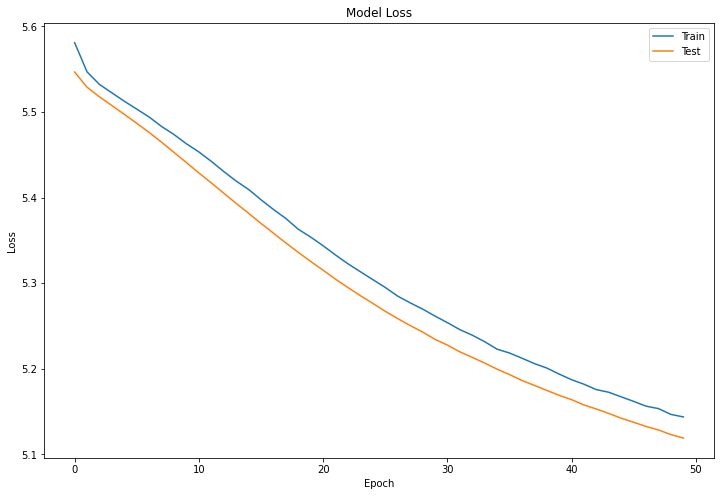

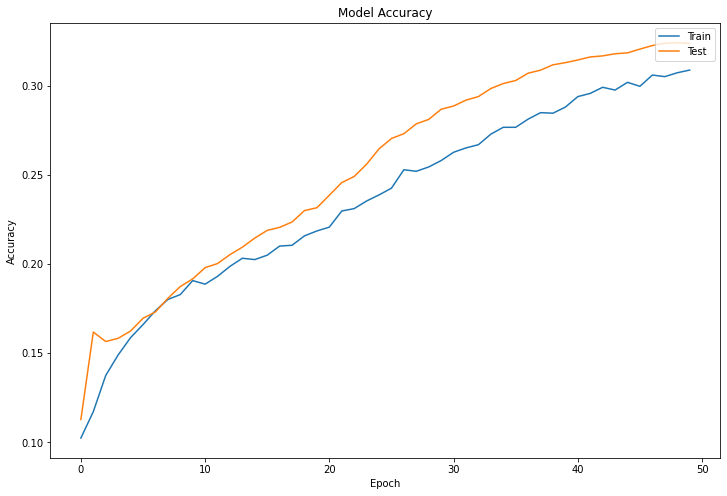

--- Time taken for training 119.4752311706543 seconds ---


In [22]:
# Train the model
trained_model = model_train(X_train_flattened, y_train, model=compiled_model, epochs=50, batch_size=64, early_stopping=False)

313/313 [==============================] - 1s 3ms/step - loss: 5.1113 - accuracy: 0.3320
Training loss: 5.109305381774902, Training accuracy: 0.33009999990463257
Validation loss: 5.1112751960754395, Validation accuracy: 0.3319999873638153


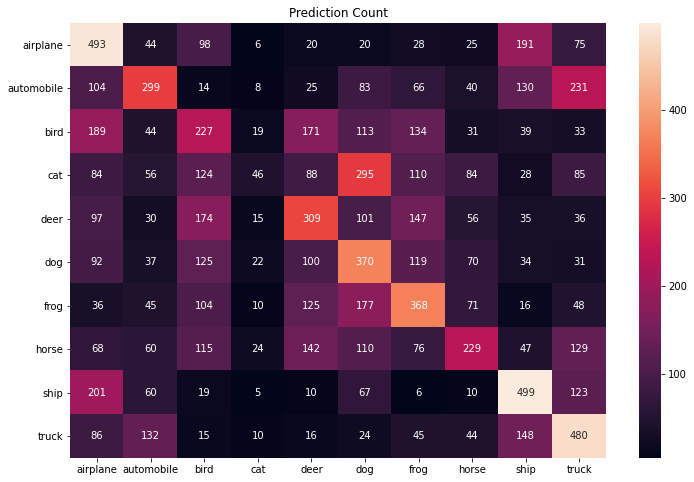

              precision    recall  f1-score   support

           0       0.34      0.49      0.40      1000
           1       0.37      0.30      0.33      1000
           2       0.22      0.23      0.23      1000
           3       0.28      0.05      0.08      1000
           4       0.31      0.31      0.31      1000
           5       0.27      0.37      0.31      1000
           6       0.33      0.37      0.35      1000
           7       0.35      0.23      0.28      1000
           8       0.43      0.50      0.46      1000
           9       0.38      0.48      0.42      1000

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.32     10000
weighted avg       0.33      0.33      0.32     10000



In [23]:
# Evaluate the model
model_evaluation(trained_model, X_train_flattened, X_test_flattened, y_train, y_test)

> **Observations:**
- Using our baseline model we are able to get ~33% training accuracy and ~33% test accuracy, which is not that great, despite having 4M trainable parameters.
- We notice that perhaps the training period is too short, just 50 epochs. 
- We note that the SGD is not optimizing the weights and biases optimally despite having a very low learning rate.
- Our baseline model struggles to identify `cats` or `birds` correctly and only guesses right on `airplanes` and `ships` about 50% of the time
- For our model to perform better we may have the change some parameters or train for a longer period of time (only the first aspect is in scope of this assignment)

---

# **Model 1: ADAM optimizer**


Our first model has the following parameters -

- ADAM optimizer
- Learning rate = 0.0001
- Batch size = 64
- Epochs = 50
- No early stopping

Since, it is our first model we want to just change the optimizer to ADAM and keep learing rate the same

  

In [24]:
# Build the model
model_adam = build_model('ADAM-model')

Model: "ADAM-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1

In [25]:
# Compile the model with ADAM optimizer and learning rate of 0.0001
compiled_model_adam = model_compile(model_adam, Adam(0.0001))

Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 4.1966 - accuracy: 0.3059 - val_loss: 3.5219 - val_accuracy: 0.3639
Epoch 2/50
625/625 [==============================] - 3s 4ms/step - loss: 3.2505 - accuracy: 0.3803 - val_loss: 3.0504 - val_accuracy: 0.3985
Epoch 3/50
625/625 [==============================] - 3s 4ms/step - loss: 2.8964 - accuracy: 0.4115 - val_loss: 2.7708 - val_accuracy: 0.4271
Epoch 4/50
625/625 [==============================] - 3s 4ms/step - loss: 2.6583 - accuracy: 0.4363 - val_loss: 2.5810 - val_accuracy: 0.4419
Epoch 5/50
625/625 [==============================] - 3s 4ms/step - loss: 2.4885 - accuracy: 0.4526 - val_loss: 2.4315 - val_accuracy: 0.4605
Epoch 6/50
625/625 [==============================] - 3s 4ms/step - loss: 2.3498 - accuracy: 0.4646 - val_loss: 2.3971 - val_accuracy: 0.4330
Epoch 7/50
625/625 [==============================] - 3s 4ms/step - loss: 2.2384 - accuracy: 0.4771 - val_loss: 2.2395 - val_accuracy: 0.4644
Epoch 

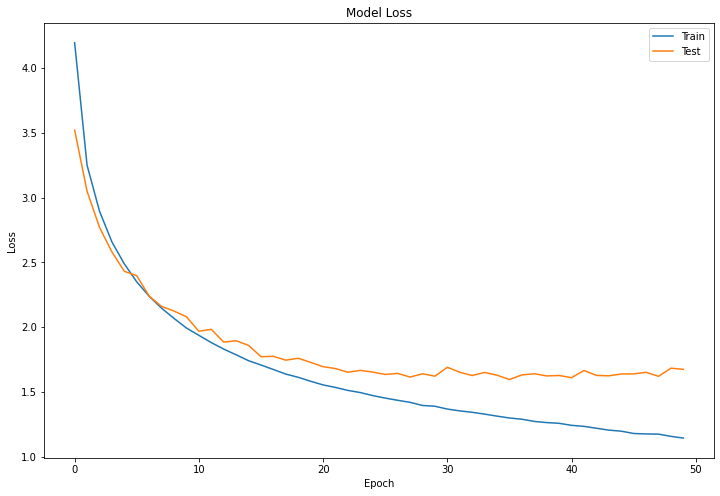

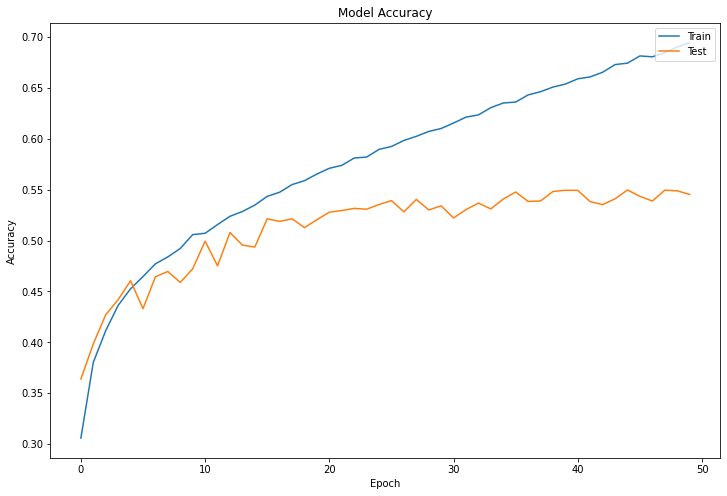

--- Time taken for training 130.69509863853455 seconds ---


In [26]:
# Train the model
trained_model_adam = model_train(X_train_flattened, y_train, model=compiled_model_adam, epochs=50, batch_size=64, early_stopping=False)

313/313 [==============================] - 1s 2ms/step - loss: 1.6629 - accuracy: 0.5427
Training loss: 1.191169023513794, Training accuracy: 0.6909599900245667
Validation loss: 1.6628539562225342, Validation accuracy: 0.5426999926567078


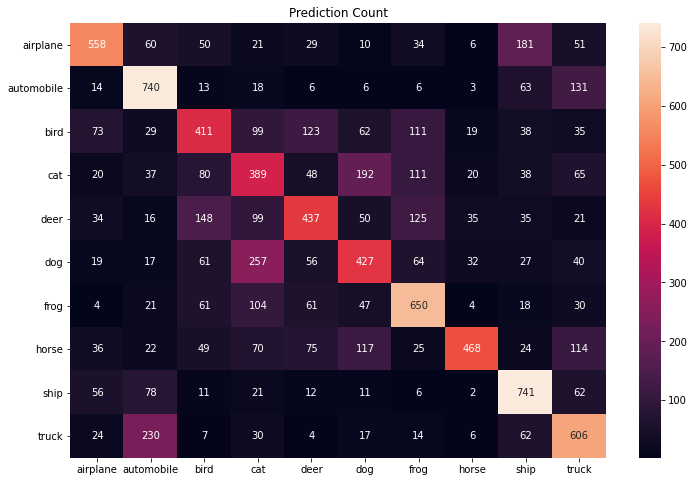

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      1000
           1       0.59      0.74      0.66      1000
           2       0.46      0.41      0.43      1000
           3       0.35      0.39      0.37      1000
           4       0.51      0.44      0.47      1000
           5       0.45      0.43      0.44      1000
           6       0.57      0.65      0.61      1000
           7       0.79      0.47      0.59      1000
           8       0.60      0.74      0.67      1000
           9       0.52      0.61      0.56      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.54     10000
weighted avg       0.55      0.54      0.54     10000



In [27]:
# Evaluate the model
model_evaluation(trained_model_adam, X_train_flattened, X_test_flattened, y_train, y_test)

> **Observations:**
- Changing our optimizer seems to have done the trick!
- Using our ADAM based model we are able to get ~67% training accuracy and ~54% test accuracy.
- Our ADAM based model struggles to identify `cats` or `birds` correctly and but performs well on `airplanes` and `ships` as well as most of the other classes.
- We also note here that the model seems to overfit on the training data provided

---

# **Model 2: ADAM optimizer and different batch-size**


Our second model has the following parameters -

- ADAM optimizer
- Learning rate = 0.0001
- Batch size = 32
- Epochs = 50
- No early stopping

Since, it is our second model we want to keep the optimizer the same as well as the learning rate and **ONLY** change the batch-size. We could have chosen to increase or decrease the batch size but for the sake of this model, we have decreased it.


  

In [28]:
# Build the model
model_adam32 = build_model('ADAM-32-model')

Model: "ADAM-32-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 10)              

In [29]:
# Compile the model with ADAM optimizer and learning rate of 0.0001
compiled_model_adam32 = model_compile(model_adam32, Adam(0.0001))

Epoch 1/50
1250/1250 [==============================] - 5s 4ms/step - loss: 3.8737 - accuracy: 0.3059 - val_loss: 3.1876 - val_accuracy: 0.3590
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.9061 - accuracy: 0.3830 - val_loss: 2.6873 - val_accuracy: 0.3978
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.5430 - accuracy: 0.4130 - val_loss: 2.4228 - val_accuracy: 0.4230
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3191 - accuracy: 0.4328 - val_loss: 2.2724 - val_accuracy: 0.4336
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1610 - accuracy: 0.4511 - val_loss: 2.1356 - val_accuracy: 0.4414
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0507 - accuracy: 0.4609 - val_loss: 2.0789 - val_accuracy: 0.4472
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9574 - accuracy: 0.4722 - val_loss: 1.9678 - val_accuracy:

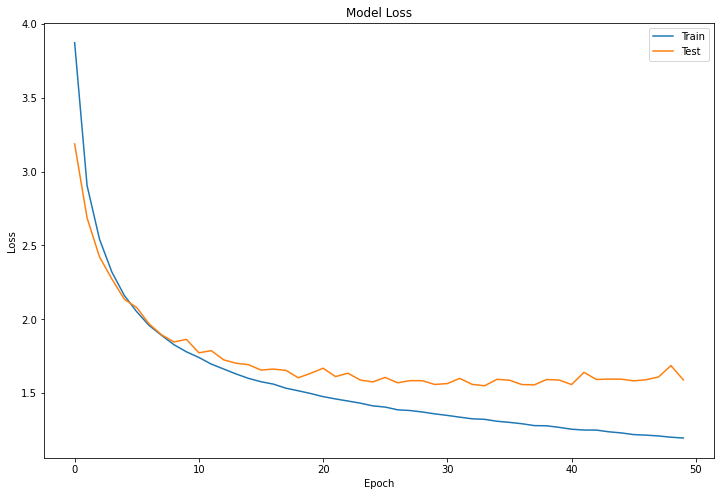

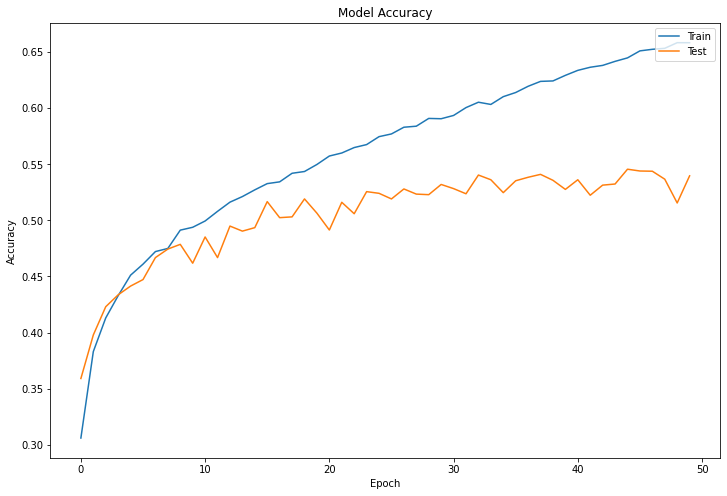

--- Time taken for training 249.62670397758484 seconds ---


In [30]:
# Train the model with batch size of 32
trained_model_adam32 = model_train(X_train_flattened, y_train, model=compiled_model_adam32, epochs=50, batch_size=32, early_stopping=False)

313/313 [==============================] - 1s 2ms/step - loss: 1.5674 - accuracy: 0.5420
Training loss: 1.2211703062057495, Training accuracy: 0.6557000279426575
Validation loss: 1.567376971244812, Validation accuracy: 0.5419999957084656


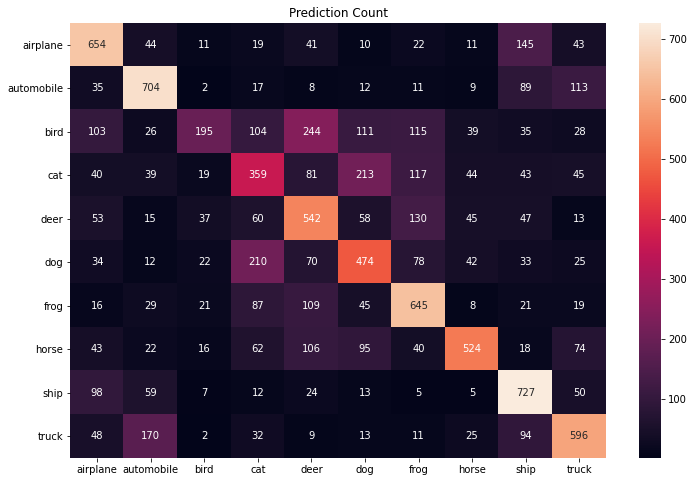

              precision    recall  f1-score   support

           0       0.58      0.65      0.62      1000
           1       0.63      0.70      0.66      1000
           2       0.59      0.20      0.29      1000
           3       0.37      0.36      0.37      1000
           4       0.44      0.54      0.49      1000
           5       0.45      0.47      0.46      1000
           6       0.55      0.65      0.59      1000
           7       0.70      0.52      0.60      1000
           8       0.58      0.73      0.65      1000
           9       0.59      0.60      0.59      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.53     10000
weighted avg       0.55      0.54      0.53     10000



In [31]:
# Evaluate the model
model_evaluation(trained_model_adam32, X_train_flattened, X_test_flattened, y_train, y_test)

> **Observations:**
- Decreasing our batch-size does not seem to have a major impact on the performznce of the model
- Using our ADAM-32 based model we are able to get ~65% training accuracy and ~53% test accuracy. This is marginally poorer that our ADAM-64 model
- We note here that it seems like the model has overfit on the training data and though it overfits lesser than the previous model the loss in generalisation is to the tune of 1%
- Our ADAM-32 based model struggles to identify `cats` or `birds` correctly and but performs well on `airplanes` and `ships` as well as most of the other classes.

---

# SOTA Model

> **NOTE:**
[PapersWithCode](https://paperswithcode.com/sota/image-classification-on-cifar-10) defines the SOTA with 99.5% accuracy, however trying to port that model as not straightforward.
For our purposes we shall use the [VGG 16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16) given in TensorFlow APIs

First, let's load the SOTA model and give it a softmax layer

In [32]:
# Download the Model
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_model = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(32,32,3) # input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

# create a sequential model with the pretrained weights for all but the last layer
sota_model= Sequential(name='sota_model')
for layer in vgg16_model.layers[:-1]:
    sota_model.add(layer)

# for the last layers flatten the layer
sota_model.add(Flatten(name='flatten_sota5'))
sota_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
sota_model.add(Dropout(0.25))
sota_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
sota_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
sota_model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
# softmax activation for final layer
sota_model.add(Dense(10, activation='softmax', name='predictions_sota5'))

58892288/58889256 [==============================] - 0s 0us/step


In [33]:
# print the model summary
sota_model.summary()

Model: "sota_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

In [34]:
# Compile the model with ADAM optimizer and learning rate of 0.0001
compiled_model_sota = model_compile(sota_model, Adam(0.0001))

In [35]:
# Here we need not flatten the inputs before feeding it to the model
X_train.shape, y_train.shape, X_test.shape, y_train.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (50000, 10))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
1250/1250 [==============================] - 55s 44ms/step - loss: 2.3514 - accuracy: 0.6465 - val_loss: 1.7396 - val_accuracy: 0.7597
Epoch 2/50
1250/1250 [==============================] - 55s 44ms/step - loss: 1.4442 - accuracy: 0.8035 - val_loss: 1.2423 - val_accuracy: 0.8248
Epoch 3/50
1250/1250 [==============================] - 55s 44ms/step - loss: 1.0269 - accuracy: 0.8579 - val_loss: 0.9716 - val_accuracy: 0.8379
Epoch 4/50
1250/1250 [==============================] - 54s 44ms/step - loss: 0.7387 - accuracy: 0.8961 - val_loss: 0.8753 - val_accuracy: 0.8405
Epoch 5/50
1250/1250 [==============================] - 55s 44ms/step - loss: 0.5410 - accuracy: 0.9203 - val_loss: 0.8287 - val_accuracy: 0.8298
Epoch 6/50
1250/1250 [==============================] - 54s 44ms/step - loss: 0.4076 - accuracy: 0.9383 - val_loss: 0.6743 - val_accuracy: 0.8521
Epoch 7/50
1250/1250 [==============================] - 55s 44ms/step - loss: 0.3047 - accuracy: 0.9528 - val_loss: 0.7101 -

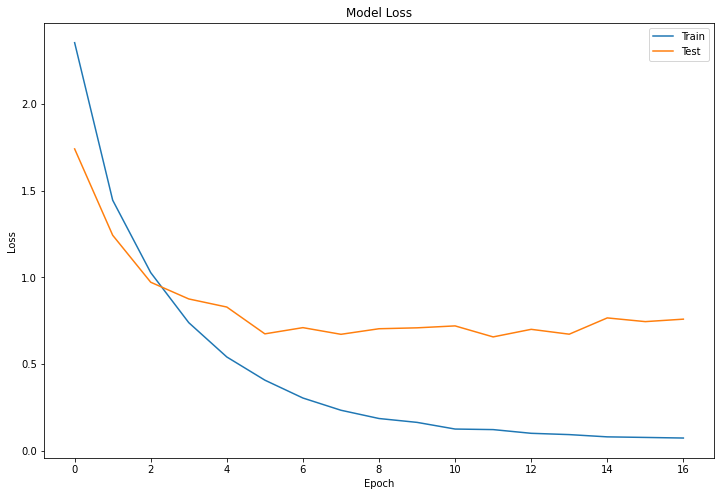

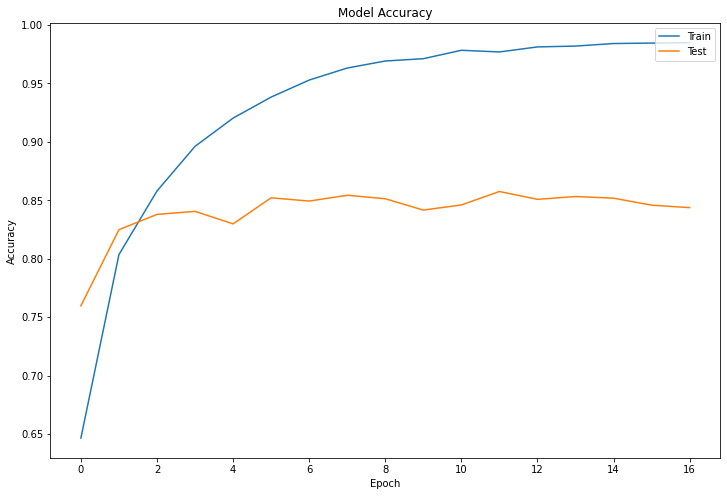

--- Time taken for training 935.1771929264069 seconds ---


In [36]:
# Train the model with batch size of 32
tf.config.run_functions_eagerly(True)

# We'll use early stopping here
trained_model_sota = model_train(X_train, y_train, model=compiled_model_sota, epochs=50, batch_size=32, early_stopping=True)

   9/1563 [..............................] - ETA: 20s - loss: 0.0604 - accuracy: 0.9896

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


313/313 [==============================] - 5s 15ms/step - loss: 0.8043 - accuracy: 0.8346
Training loss: 0.21660320460796356, Training accuracy: 0.9555400013923645
Validation loss: 0.8042500019073486, Validation accuracy: 0.8345999717712402


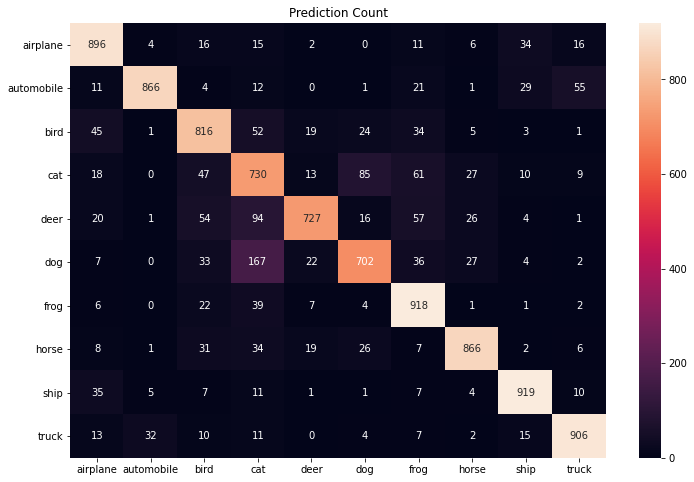

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1000
           1       0.95      0.87      0.91      1000
           2       0.78      0.82      0.80      1000
           3       0.63      0.73      0.67      1000
           4       0.90      0.73      0.80      1000
           5       0.81      0.70      0.75      1000
           6       0.79      0.92      0.85      1000
           7       0.90      0.87      0.88      1000
           8       0.90      0.92      0.91      1000
           9       0.90      0.91      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.84     10000
weighted avg       0.84      0.83      0.84     10000



In [37]:
# Evaluate the model
model_evaluation(trained_model_sota, X_train, X_test, y_train, y_test)

---

# Comparison of models

The following table tabulates our findings - 


| Model Name 	| Model Type 	| Parameters 	| Optimizer 	| Batch size 	| Training Accuracy 	| Validation Accuracy 	|
|:----------:	|:----------:	|:----------:	|:---------:	|:----------:	|:-----------------:	|:-------------------:	|
|  Baseline  	|     MLP    	|    4.1M    	|    SGD    	|     64     	|         33%        	|          33%         	|
|   ADAM-64  	|     MLP    	|    4.1M    	|    ADAM   	|     64     	|         67%        	|          54%         	|
|   ADAM-32  	|     MLP    	|    4.1M    	|    ADAM   	|     32     	|         65%        	|          53%         	|
| VGG16-SOTA 	|     CNN    	|     16M    	|    ADAM   	|     32     	|        96%        	|         85%         	|

Here are our final notes -

- Baseline model performs poorly because the optimizer used SGD, which converges too slowly
- ADAM-64 is a considerable improvement on the baseline. An increase of 21% in validation accuracy.
- ADAM-32, however, is at par with ADAM-64. We posit that the difference in these two models is tough to gleam over just 50 epochs.
- VGG-16 (our SOTA) is a pretrained CNN model. As such, it is better suited to image classifications tasks. Note that it overfitted on the training data but still gives us the highest validation accuracy amongst the considered models
- Finally, ADAM-64 and ADAM-32 both do considerably well on classifying `airplanes, trucks, horses, ships, automobiles, frogs` but struggle with `cats, dogs, deers, birds`. SOTA on the other hand only misclassifies certain `cats and dogs`, which is understandable because they are both furry domestic four-legged animals.

